(Root_tutorial)=

# Symbolic Root Finding
:::{post} June 12, 2025 
:tags: optimization, root finding, worked examples, tutorial
:category: beginner, explanation 
:author: Jesse Grabowski
:::


When faced with problems involving systems of nonlinear equations, it is rare to actually have access to analytic solutions for the zeros of the system. Nevertheless, these zeros are often important to downstream tasks. A common application is in perturbation theory, where we seek to linearize a nonlinear system around the fixed points of that system.

To find such fixed points, numerical algorithms such as Newton-Raphson and Broyden's Method are typically utilized. Once you have written down your system symbolically in Pytensor, it is always possible to compile the function (and, if desired, the jacobian of the system), then pass these compiled functions to a numerical solver of your choice.

This solution can be incomplete, however, in cases where one is interested in using the roots as an intermediate computation in a larger graph. Compiling the function breaks the graph, causing:

1. Pytensor to not see optimizations, such as re-use of computation, between the two halves, and;
2. We cannot get end-to-end gradients, because the optimization step happens outside of pytensor.

To address these limitations, pytensor offers *symbolic* root finding via the `pytensor.tensor.optimize.root` function.

In [1]:
import pytensor
import pytensor.tensor as pt

import numpy as np
import matplotlib.pyplot as plt

## Basic Usage

To use `tensor.optimize.root`, first set up a system of equations. The first test function we will look at is:

$$ 
\begin{align}
x^2 - y - 1 &= 0 \\
x - y^2 + 1 &= 0 
\end{align}
$$

This system is analytically tractible. Two roots are immediately visible by simple inspection (aka experience-based guess-and-check): $x=0, y=-1$, and by symmetry, $x=-1, y=0$. 

Remaining roots can be found by solving the first equation for y and plugging in the result to the second:

$$
\begin{align}
y &= x^2 - 1 \\
x - (x^2 - 1)^2 +1 &= 0 \\
x -x^4 + 2x^2 -1 + 1 &= 0 \\
x^4 - 2x^2 - x &= 0 \\
x (x^3 - 2x - x) &= 0
\end{align}
$$

As already noted, $x = 0$ is a root, and we see it here. We also can see from inspecting $x^3 - 2x - x$ that $x=-1$ is also a root. Remove the root $x = -1$ from the cubic expression by dividing it by $x+1$ to reduce it to a quadratic factor:

$$
\begin{align}
\frac{x^3 - 2x - x}{x + 1} = x^2 - x - 1
\end{align}
$$

Which leads to two roots:

$$x = -\frac{-1 \pm \sqrt{5}}{2}$$

Plugging this expression back into equation 1:

$$ \begin{align}
y &= \left ( \frac{-1 \pm \sqrt{5}}{2} \right)^2 - 1 \\
y &= \begin{cases} -\left ( \frac{-1 + \sqrt{5}}{2} \right)^2 - 1 &  =  -\frac{-1 + \sqrt{5}}{2} \\
                   - \left ( \frac{-1 - \sqrt{5}}{2} \right)^2 - 1 & = -\frac{-1 - \sqrt{5}}{2}
    \end{cases}
\end{align}
$$

Whichever branch we choose, the value for $x$ and $y$ are the same. So the four roots are:

$$
\begin{align}
x &= 0, & y &=-1 \\
x &= -1, & y&= 0 \\
x &= -\frac{-1 - \sqrt{5}}{2}, & y&= -\frac{-1 - \sqrt{5}}{2} \\
x &= -\frac{-1 + \sqrt{5}}{2}, & y&= -\frac{-1 + \sqrt{5}}{2}
\end{align}
$$

In the next cell, we plot this system of equations, and mark the four roots.

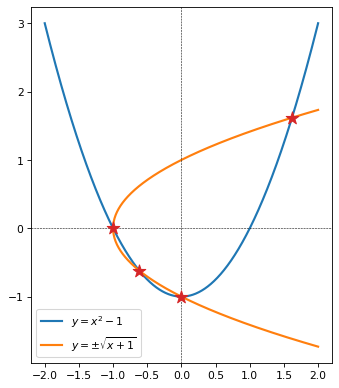

In [2]:
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'}, dpi=77, figsize=(14, 6))

x_plot = np.linspace(-2, 2, 1000)
ax.plot(x_plot, x_plot ** 2 - 1, color='tab:blue', lw=2, label=r'$y = x^2 - 1$')

with np.errstate(all='ignore'):
    ax.plot(x_plot, np.sqrt(x_plot + 1), color='tab:orange', lw=2, label=r'$y = \pm \sqrt{x + 1}$')
    ax.plot(x_plot, -np.sqrt(x_plot + 1), color='tab:orange', lw=2)
    
ax.axhline(0, ls='--', c='k', lw=0.5)
ax.axvline(0, ls='--', c='k', lw=0.5)

quad_root_1 = -(-1 + np.sqrt(5)) / 2
quad_root_2 = -(-1 - np.sqrt(5)) / 2

for x, y in [(0, -1), (-1, 0), (quad_root_1, quad_root_1), (quad_root_2, quad_root_2)]:
    ax.scatter(x, y, color='tab:red', marker='*', zorder=100, s=150)

ax.legend()
plt.show()

To find roots of our system using pytensor, we first have to symbolically set it up. 

Currently, all variables need to be provided in a single vector. So we first make a vector (called `variables`) of length 2, then unpack it into `x` and `y`. I use fancy python double-assignment to do this.

`x` and `y` are then used to type in our equations. Like scipy, we need to rewrite the system so that the right-hand size is always zero. In this case we already had that, but in general you will need to keep this in mind.

In [3]:
x, y = variables = pt.tensor('variables', shape=(2, ))

eq_1 = x ** 2 - y - 1
eq_2 = x - y ** 2 + 1

To make a compute graph with a root finder, use `pt.optimize.root`. The function expects:

- A vector of equations to solve, `equations`
- A vector of variables with respect to which the equations will be solved, `variables`
- Configuration arguments, like `method`, `jac` and `optimizer_kwargs`, which are forwarded to `scipy.optimize.root`.

In [4]:
solution, success = pt.optimize.root(equations=pt.stack([eq_1, eq_2]), 
                       variables=variables,
                       method='hybr',
                       optimizer_kwargs={'tol':1e-8})

Looking at the graph for the `solution`, we can see that the outer function takes `variables` as input and returns the first output of `RootOp` (the solution).

It also has an inner graph with two outputs. The first is a `MakeVector` (this is `pt.stack`), combining `eq1` and `eq2`. So the first inner graph simply computes the equations we provided. The second graph is a `Scan` -- this is the $2\times2$ Jacobian matrix of the system of the system:

$$ 
J = \begin{bmatrix} \frac{\partial f_1(x,y)}{\partial x} & \frac{\partial f_1(x,y)}{\partial y} \\
                        \frac{\partial f_2(x,y)}{\partial x} & \frac{\partial f_2(x,y)}{\partial y} 
    \end{bmatrix} 
$$

Pytensor happens to compute this matrix using a `Scan`, so that's why one appears here.

So notice that we don't have to compute the Jacobian for this ourselves -- it's automatically by pytensor! Also pytensor can see all these inner functions and optimize across them. 

In [5]:
solution.dprint()

RootOp(method=hybr, jac=True).0 [id A]
 └─ variables [id B]

Inner graphs:

RootOp(method=hybr, jac=True) [id A]
 ← MakeVector{dtype='float64'} [id C]
    ├─ Sub [id D]
    │  ├─ Sub [id E]
    │  │  ├─ Pow [id F]
    │  │  │  ├─ Subtensor{i} [id G]
    │  │  │  │  ├─ variables [id H]
    │  │  │  │  └─ 0 [id I]
    │  │  │  └─ 2 [id J]
    │  │  └─ Subtensor{i} [id K]
    │  │     ├─ variables [id H]
    │  │     └─ 1 [id L]
    │  └─ 1 [id M]
    └─ Add [id N]
       ├─ Sub [id O]
       │  ├─ Subtensor{i} [id G]
       │  │  └─ ···
       │  └─ Pow [id P]
       │     ├─ Subtensor{i} [id K]
       │     │  └─ ···
       │     └─ 2 [id Q]
       └─ 1 [id R]
 ← Add [id S]
    ├─ Blockwise{IncSubtensor{i}, (i00),(),()->(o00)} [id T]
    │  ├─ ExpandDims{axis=0} [id U]
    │  │  └─ Second [id V]
    │  │     ├─ variables [id H]
    │  │     └─ ExpandDims{axis=0} [id W]
    │  │        └─ 0.0 [id X]
    │  ├─ Add [id Y]
    │  │  ├─ Mul [id Z]
    │  │  │  ├─ Mul [id BA]
    │  │  │  │  

Since we're not doing anything with the outputs, we're ready to compile a function. We don't have any parameters, so we just pass in the variables -- which are treated as the inital values -- and pass back the solution and success flag. 

In [6]:
fn = pytensor.function([variables],
                       [solution, success])

Looking at the final graph, we see how both outputs -- the system of equations and the jacobian -- become simplified.

In [7]:
fn.dprint(print_shape=True)

RootOp(method=hybr, jac=True).0 [id A] shape=(2,) 0
 └─ variables [id B] shape=(2,)
RootOp(method=hybr, jac=True).1 [id A] shape=() 'success' 0
 └─ ···

Inner graphs:

RootOp(method=hybr, jac=True) [id A]
 ← MakeVector{dtype='float64'} [id C] shape=(2,)
    ├─ Composite{((-1.0 + sqr(i0)) - i1)} [id D] shape=()
    │  ├─ Subtensor{i} [id E] shape=()
    │  │  ├─ variables [id F] shape=(2,)
    │  │  └─ 0 [id G] shape=()
    │  └─ Subtensor{i} [id H] shape=()
    │     ├─ variables [id F] shape=(2,)
    │     └─ 1 [id I] shape=()
    └─ Composite{((1.0 + i1) - sqr(i0))} [id J] shape=()
       ├─ Subtensor{i} [id H] shape=()
       │  └─ ···
       └─ Subtensor{i} [id E] shape=()
          └─ ···
 ← IncSubtensor{:, i} [id K] shape=(2, 2)
    ├─ IncSubtensor{:, i} [id L] shape=(2, 2)
    │  ├─ Alloc [id M] shape=(2, 2)
    │  │  ├─ [[0.]] [id N] shape=(1, 1)
    │  │  ├─ 2 [id O] shape=()
    │  │  └─ 2 [id P] shape=()
    │  ├─ Composite{((i0 * i1) + i2)} [id Q] shape=(2,)
    │  │  ├─ [2

Checking some points. We see that starting at $0, 0$, we converge to $x, y = \frac{-1 - \sqrt{5}}{2} \approx -0.618$.

In [8]:
fn([0., 0.])

[array([-0.61803399, -0.61803399]), np.True_]

Starting at $1,1$, we converge to $x, y = \frac{-1 + \sqrt{5}}{2} \approx 1.618$

In [9]:
fn([1., 1.])

[array([1.61803399, 1.61803399]), np.True_]

Starting at $-1, 1$, we converge to $x=-1, y=0$

In [10]:
fn([-1, 1])

[array([-1.00000000e+00, -1.26918883e-12]), np.True_]

And starting at $1, -1$, we converge to $x=0, y=-1$

In [11]:
fn([1, -1])

[array([-1.2693032e-12, -1.0000000e+00]), np.True_]

## Graph manipulation

Since the `root` Op is fully symbolic, we can manipulate its graph as much as we like. 

For example, we can vectorize it. This will allow us to test many points at the same time. To do this, we create a new variable with a batch dimension, then rewrite the graph to work out the resulting dimensions.

In [12]:
from pytensor.graph.replace import vectorize_graph

variables_grid = pt.tensor('x', shape=(None, 2))
grid_of_solutions = vectorize_graph([solution, success], 
                                    {variables:variables_grid})


Compile the new, vectorized function

In [13]:
fn_vec = pytensor.function([variables_grid],
                        grid_of_solutions)

Now that we're vectorized, the input will be a 2d array of values, with the first column representing `x`, and the second column `y`. 

To quickly get a bunch of pairs of values, we can use `np.meshgrid`.

In [14]:
x_values = np.linspace(-2, 2, 30)
xx, yy = np.meshgrid(x_values, x_values)
grid_values = np.c_[xx.ravel(), yy.ravel()]

In [15]:
solution_grid, success_grid = fn_vec(grid_values)

unique_solutions = np.unique(np.round(solution_grid, 3), axis=0)
solution_ids = {tuple(v.tolist()): k for k, v in enumerate(unique_solutions)}

Across all the solution, we found only the four roots we expected, which is great!

In [16]:
unique_solutions

array([[-1.   , -0.   ],
       [-0.618, -0.618],
       [ 0.   , -1.   ],
       [ 1.618,  1.618]])

We can make a nice plot to see that roots roughly correspond to the four graph quadrents. But there are some exceptions, especially near the origin. 

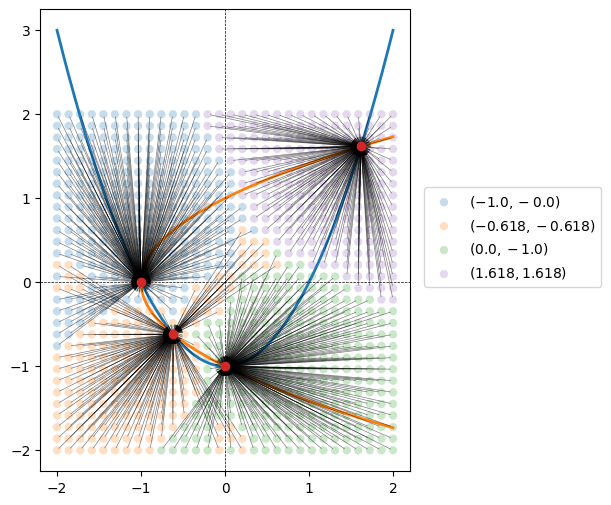

In [17]:
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(14, 6))

x_plot = np.linspace(-2, 2, 1000)
ax.plot(x_plot, x_plot ** 2 - 1, color='tab:blue', lw=2)

with np.errstate(all='ignore'):
    ax.plot(x_plot, np.sqrt(x_plot + 1), color='tab:orange', lw=2)
    ax.plot(x_plot, -np.sqrt(x_plot + 1), color='tab:orange', lw=2)
    
ax.axhline(0, ls='--', c='k', lw=0.5)
ax.axvline(0, ls='--', c='k', lw=0.5)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

rounded_solutions = np.round(solution_grid, 3)

for root, color in zip(unique_solutions, colors):
    subset_idx = (rounded_solutions == root).all(axis=1)
    subset = grid_values[subset_idx]
    ax.scatter(*subset.T, facecolor=color, edgecolor='none', alpha=0.25, label=fr'$({root[0]}, {root[1]})$')
    ax.scatter(*root, color='tab:red', zorder=1000)
    for x0 in subset:
        ax.annotate(xy=root, xytext=x0, text='', arrowprops={'arrowstyle':'->', 'linewidth':0.5, 'alpha':0.5})

fig.legend(ncol=1, bbox_to_anchor=(0.65, 0.5), loc='center left')
plt.show()

## A function with parameters

Our first function was really simple. More commonly, a function of interest will have both variables and parameters. 

To keep things simple, we can add a coefficent in front of every term in our system of two equations:

$$ 
\begin{align}
ax^2 + by + c &= 0 \\
dx + ey^2 + f &= 0 
\end{align}
$$

Although this still looks quite simple, we no longer have a general analytic solution! If we are faced with a parameterized function like like "in the wild", we have no choice but to resort to numerical methods.


To get back to what we've been looking at, we can set:  $a=1$, $b=-1$, $c=-1$, $d=1$, $e=-1$, $f=1$

In [18]:
x, y = variables = pt.tensor('variables', shape=(2, ))
a, b, c, d, e, f = pt.scalars('a b c d e f'.split())

eq_1 = a * x ** 2 + b * y + c
eq_2 = d * x + e * y ** 2 + f

Notice that we don't change the call to `optimize.root` at all!

In [19]:
solution, success = pt.optimize.root(equations=pt.stack([eq_1, eq_2]), 
                       variables=variables,
                       method='hybr',
                       optimizer_kwargs={'tol':1e-8})

Unlike `scipy.optimize.root`, pytensor is going to automatically figure out what additional arguments are required. By knowing `equations` and `variables`, pytensor analyses the implied subgraph, and collects all other unknowns as `args`.

We can see now that the inputs to the `RootOp` are `variables`, then all the parameters. Otherwise, the graph is unchanged. As a user, though, you will never interact with this inner function! You just pass the parameter values and pytensor will figure out the rest.

In [20]:
solution.dprint()

RootOp(method=hybr, jac=True).0 [id A]
 ├─ variables [id B]
 ├─ f [id C]
 ├─ e [id D]
 ├─ d [id E]
 ├─ c [id F]
 ├─ b [id G]
 └─ a [id H]

Inner graphs:

RootOp(method=hybr, jac=True) [id A]
 ← MakeVector{dtype='float64'} [id I]
    ├─ Add [id J]
    │  ├─ Add [id K]
    │  │  ├─ Mul [id L]
    │  │  │  ├─ a [id M]
    │  │  │  └─ Pow [id N]
    │  │  │     ├─ Subtensor{i} [id O]
    │  │  │     │  ├─ variables [id P]
    │  │  │     │  └─ 0 [id Q]
    │  │  │     └─ 2 [id R]
    │  │  └─ Mul [id S]
    │  │     ├─ b [id T]
    │  │     └─ Subtensor{i} [id U]
    │  │        ├─ variables [id P]
    │  │        └─ 1 [id V]
    │  └─ c [id W]
    └─ Add [id X]
       ├─ Add [id Y]
       │  ├─ Mul [id Z]
       │  │  ├─ d [id BA]
       │  │  └─ Subtensor{i} [id O]
       │  │     └─ ···
       │  └─ Mul [id BB]
       │     ├─ e [id BC]
       │     └─ Pow [id BD]
       │        ├─ Subtensor{i} [id U]
       │        │  └─ ···
       │        └─ 2 [id BE]
       └─ f [id BF]
 ← Add [id

In [21]:
fn = pytensor.function([variables, a, b, c, d, e, f],
                       [solution, success])

In [22]:
arg_inputs = {'a': 1, 'b': -1, 'c': -1, 'd': 1, 'e': -1, 'f': 1}

We can double-check that we still get the same answers:

In [23]:
fn([0., 0.], **arg_inputs)

[array([-0.61803399, -0.61803399]), np.True_]

In [24]:
fn([1., 1.], **arg_inputs)

[array([1.61803399, 1.61803399]), np.True_]

## Gradients

Since `root` is symbolic `Op`, we can backprop through it. To do this, we use the implicit value theorem. We have a function $f(x, \theta)$, where $x$ are the variables, and $\theta$ are the parameters. There's some optimal $x^\star$ that depends on $\theta$ such, such that $f(x^\star(\theta), \theta) = 0$ 

If we take $\frac{\partial}{\partial \theta} f(x^\star(\theta), \theta)$ and use the chain rule, we get:


$$
\begin{align}
\frac{\partial}{\partial \theta} f(x^\star(\theta), \theta) &= \frac{\partial f \left ( x^\star(\theta), \theta \right )}{\partial x^\star} \frac{x^\star(\theta)}{\partial \theta} + \frac{\partial f(x^\star(\theta), \theta)}{\partial \theta} \Rightarrow \\
0 &= \left. \frac{\partial f \left ( x, \theta \right )}{\partial x} \right|_{x = x^\star} \frac{\partial x^\star(\theta)}{\partial \theta} + \left. \frac{\partial f(x, \theta)}{\partial \theta} \right |_{x = x^\star}
\end{align}
$$

The zero arises because, by definition, $f(x^\star(\theta), \theta) = 0$. All three of the terms in this expression are matrices, and we know 2 of them. As a result, we can directly solve for the unknown quantity of interest, $\frac{\partial x^\star(\theta)}{\partial \theta}$:

$$
\frac{\partial x^\star(\theta)}{\partial \theta} = - \left(\left. \frac{\partial f \left ( x, \theta \right )}{\partial x} \right|_{x = x^\star}\right)^{-1} \left. \frac{\partial f(x, \theta)}{\partial \theta} \right |_{x = x^\star}
$$

So we just need the jacobian of the objective function with respect to the variables $x$ and parameters $\theta$, all evaluated at the optimal point $x^\star$. 

In [25]:
dx_dtheta = pt.grad(solution[0], [a, b, c, d, e, f])
dy_dtheta = pt.grad(solution[1], [a, b, c, d, e, f])

d_theta_vec = pt.stack([dx_dtheta, dy_dtheta], axis=-1)

f_d_theta = pytensor.function([variables, a, b, c, d, e, f], d_theta_vec)

These values show, evidently, the effect of a nudge to one of the 6 parameteres (on the rows) on the value of the variables $x$ and $y$ (on the columns). 

In [26]:
f_d_theta([0., 0.], **arg_inputs)

array([[ 0.89442719, -0.7236068 ],
       [-1.4472136 ,  1.17082039],
       [ 2.34164079, -1.89442719],
       [-1.17082039,  1.4472136 ],
       [ 0.7236068 , -0.89442719],
       [ 1.89442719, -2.34164079]])

Note that this is unique to the root associated with the $(0, 0)$ point. If we shift the point $(0, 0)$ slightly, but still in a zone that converges to the $(-0.618, -0.618)$ root, we will get the same gradients

In [27]:
f_d_theta([-1.0, -1.0], **arg_inputs)

array([[ 0.89442719, -0.7236068 ],
       [-1.4472136 ,  1.17082039],
       [ 2.34164079, -1.89442719],
       [-1.17082039,  1.4472136 ],
       [ 0.7236068 , -0.89442719],
       [ 1.89442719, -2.34164079]])

On the other hand, if we evaluate at a different root, for example the $(1.618, 1.618)$ root, we will have different gradients.

In [28]:
f_d_theta([0.8, 0.8], **arg_inputs)

array([[-0.89442719, -0.2763932 ],
       [-0.5527864 , -0.17082039],
       [-0.34164079, -0.10557281],
       [ 0.17082039,  0.5527864 ],
       [ 0.2763932 ,  0.89442719],
       [ 0.10557281,  0.34164079]])

## Using roots for downstream computation

Often, there are quantities of interest downstream of an optimization problem that researchers are interested in studying.

One such example comes from labor economics. The [McCall Search Model](https://python.quantecon.org/mccall_model.html) is a relatively simple model of how people look for jobs. Every day, an unemployed worker wakes up and gets a job offer. The wage of the job on offer that day (at time $t$) is drawn from a known distribution $w_t \sim Q(\cdot)$. Offers are IID across time.

The workers can either:

1. Accept the job and work it for the rest of his life, earning $w_t$ forever, or;
2. Reject the job, and wait for another one to come along. In this case, he earns unemployment benefits $c$, and gets to see another offer tomorrow.

The agent's objective is to maxmize expected discounted utility over his lifetime. We assume he discounts at rate $\beta$, such that:

$$ U_t = \mathbb E_t \left [\sum_{s=0}^\infty \beta^s y_{t+s} \right ] $$

Where $y_t$ is the the income the worker will earn at period $t$, either $c$ or $w_\tau$, depending on his choices up to that point ($\tau$ is the period in which he accepted the wage, if he did).

Interested readers can check the quantecon link for details. For our purposes here, it suffices to say that this is a dynamic program involving a search for an optimal **value function**. A value function maps states of the world to expected utility, allowing an agent to evaluate actions. With some manipulation, it can be shown that the worker in this model has the following value function:

$$ v^\star(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^\star(w') q (w')
    \right\}
$$

Where $w$ is a vector of all known wages (or at least some kind of sampling over the support of the wage distribution, $\mathbb{W}$). So $v$, $w$ and $q(w)$ are all vectors. By $v^\star(w)$, we mean the value of a wage offer $w$ under the optimal value function, $v^\star$.

Because of the special properties of this value function, it can be shown that it defines a **fixed-point operator** $T$. Starting an arbitrary vector $v_0$, iteratively applying the following function:

$$
Tv_i
= \max \left\{
        \frac{w_i}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
$$

Will eventaully converge to the optimal value function, no matter what $v_0$ is chosen.

### Where's the root?

What quantecon presents is **value function iteration**. We can, however, just jump to the end by interpreting the definition of the fixed-point operator $Tv$ as a system of non-linear equations. In particular, we just require some vector $v$ such that:

$$
\begin{align}
Tv - v &= 0 && \Rightarrow  \\
\max \left\{
        \frac{w}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\} - v &= 0 &&
\end{align}
$$

Such a vector will contain all the **roots** of this equation. We can find the answer directly, without using value-function iteration.

### Where do wages come from?

This is a free choice in the model. Following QuantEcon, we will assume they follow a *Beta-Binomial Distribution*. Pytensor implements this random variable and can draw samples from it, but it doesn't give us the PMF out of the box. We have to write it ourselves, using the definition from [Wikipedia](https://en.wikipedia.org/wiki/Beta-binomial_distribution):

$$
f(x\mid n,\alpha,\beta)
= \begin{pmatrix} n \\ k \end{pmatrix} \frac{B(x + \alpha, n - x + \beta)}{B(\alpha, \beta)}
$$

Where $B(x, y)$ is the Beta function.

For numerical stability, we will actually compute the logpmf, then exp it.

In [29]:
from pytensor.tensor.special import betaln

n, a, b = pt.scalars('n a b'.split())
w_min, w_max = pt.scalars('w_min w_max'.split())

w_support = pt.linspace(w_min, w_max, n+1)

k = pt.floor(w_support)
ln_n_choose_k = -pt.log(n + 1) - betaln(n - k + 1, k + 1)
q_probs = pt.exp(ln_n_choose_k + betaln(k + a, n - k + b) - betaln(a, b))

In [30]:
dist_args = [n, a, b, w_min, w_max]
f = pytensor.function(dist_args, [w_support, q_probs])

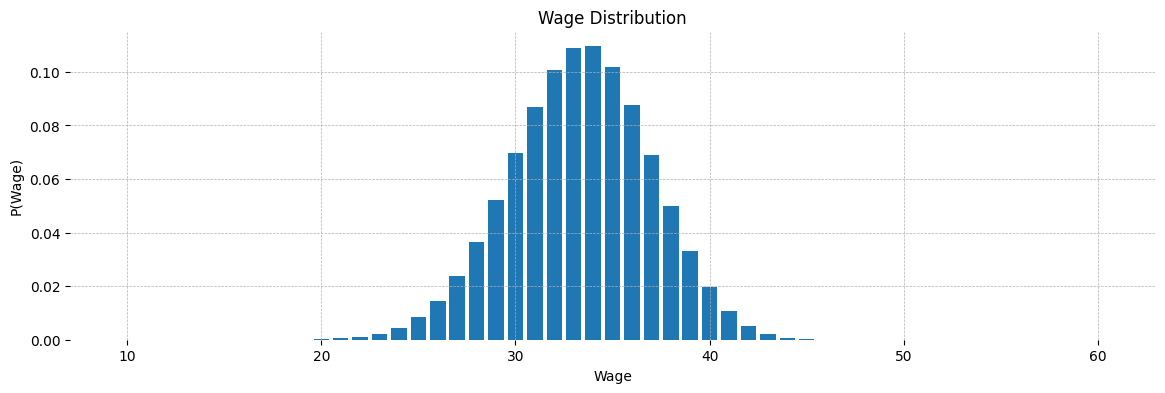

In [31]:
dist_params = {'n':50, 'a':200, 'b':100, 'w_min':10, 'w_max':60}

fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(*f(**dist_params))
ax.set(title='Wage Distribution', xlabel='Wage', ylabel='P(Wage)')
ax.grid(ls='--', lw=0.5)
[spine.set_visible(False) for spine in ax.spines.values()]
plt.show()

### Setting up the model

In [32]:
c = pt.dscalar('c') # Unemployment benefit
β = pt.dscalar('β') # Discount rate

# initial value function guess
v0 = pt.dvector('v0') 

# Fixed-point operator
T = pt.maximum(w_support / (1 - β), c + β * pt.dot(v0, q_probs))

v_star, success = pt.optimize.root(equations=T - v0,
                                   variables=v0,
                                   method='hybr')

In [33]:
fn = pytensor.function([v0, c, β, *dist_args],
                       [w_support, v_star, success])

### Solving for the value function

In [34]:
c_value = 25
beta_value = 0.99
v0_value = np.zeros(dist_params['n'] + 1)

w_values, v_star_val, success_flag = fn(v0_value, c_value, beta_value, **dist_params)

This plot shows the optimal value function. Below the reservation wage (which appears to be around 38), the worker will not accept a job, and gets constant utility from being on unemployment. After the reservation wage, his lifetime utility is increasing linearly in his wage level. 

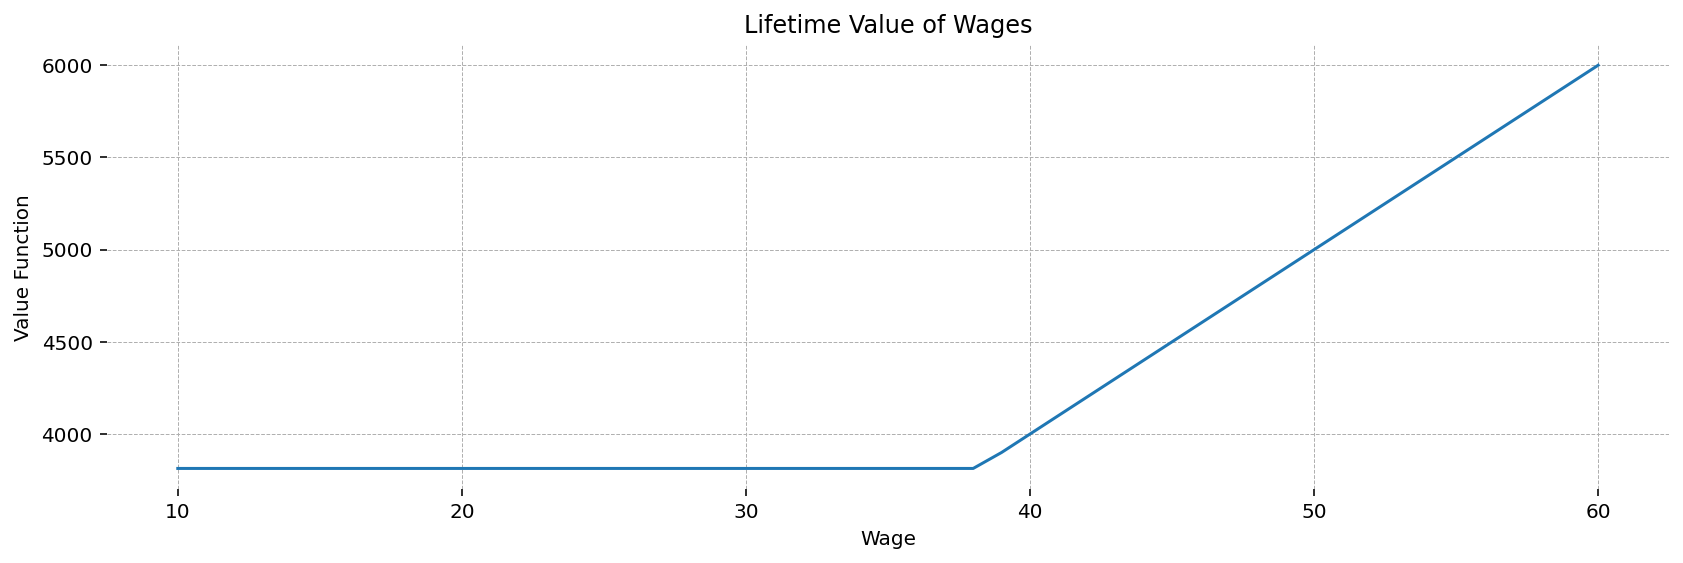

In [35]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
ax.plot(w_values, v_star_val)
ax.set(title='Lifetime Value of Wages', xlabel='Wage', ylabel='Value Function')
ax.grid(ls='--', lw=0.5)
[spine.set_visible(False) for spine in ax.spines.values()]
plt.show()

### Studying the reservation wage

While the shape of the value function is interesting per se, it is not the primary object of interest in this study. Instead, we are interested in the reservation wage -- the minimum wage at which the worker will willingly choose to exit unemployment and join the workforce.

This wage can be computed as:

$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') q (w') \right\}
$$

In [36]:
w_bar = (1 - β) * (c + β * pt.dot(v_star, q_probs))

# We want to study the impact of change in unemployment and patience on the reserve wage 
w_grads = pt.grad(w_bar, [c, β])

TypeError: Only tensors with the same number of dimensions can be joined. Input ndims were: [3, 2, 2, 2]

In [38]:
fn_2 = pytensor.function([v0, c, β, *dist_args],
                         [success, w_bar, *w_grads],
                         on_unused_input='ignore')

NameError: name 'w_grads' is not defined

In [39]:
success_flag, reservation_wage, dw_dc, dw_dβ = fn_2(v0_value, c_value, beta_value, **dist_params)
print(f'Reservation wage at c={c_value}, β={beta_value}: {reservation_wage.item()}')
print(f'Change in reservation wage given unit change in c: {dw_dc}')
print(f'Change in reservation wage given 1% change in β: {dw_dβ / 100}')

NameError: name 'fn_2' is not defined

We likely want to study the effect of many pairs of c and $\beta$, so we vectorize the function

In [40]:
c_grid = pt.dmatrix('c_grid')
β_grid = pt.dmatrix('β_grid')

w_bar_grid, *w_grad_grid = vectorize_graph([w_bar, *w_grads], {β:β_grid, c:c_grid})

fn_grid = pytensor.function([v0, c_grid, β_grid, *dist_args],
                            [w_bar_grid, *w_grad_grid],
                            on_unused_input='ignore')

NameError: name 'w_grads' is not defined

In [40]:
c_values = np.linspace(10, 50, 30)
β_values = np.linspace(0.1, 0.99, 30)

cc, bb = np.meshgrid(c_values, β_values)

In [41]:
# Use the answer we already found as starting value to try to speed up convergence

w_bar_grid_vals, *w_grad_grid_vals = fn_grid(v_star_val, cc, bb,
                                             **dist_params)

This next cell reproduces the final plot of the quantecon lecture

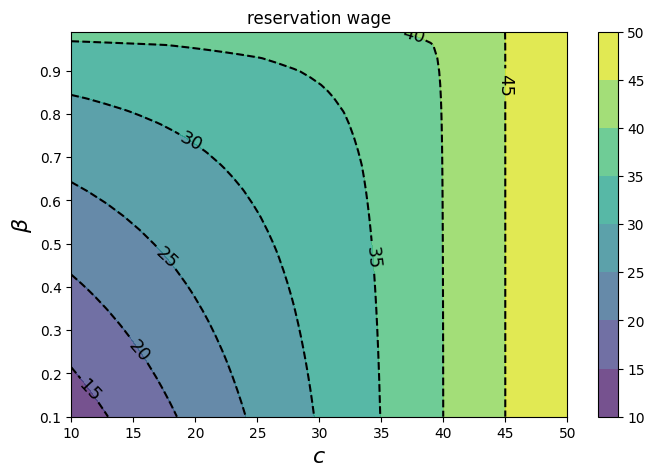

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))
cs1 = ax.contourf(cc, bb, w_bar_grid_vals, alpha=0.75)
ctr1 = ax.contour(cc, bb, w_bar_grid_vals, colors='k', linestyles='dashed', )

ax.clabel(ctr1, inline=1, fontsize=13, colors='k')
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

Since we have the gradients, we can also show a vector field of how the reservation wage changes at each point.

From this perspective, we see that the reservation wage increases more when $c$ is increased by \\$1 than when $\beta$ is increased by 1\%. The gradients primarily point in the $c$ direction, except when $c < 20$.

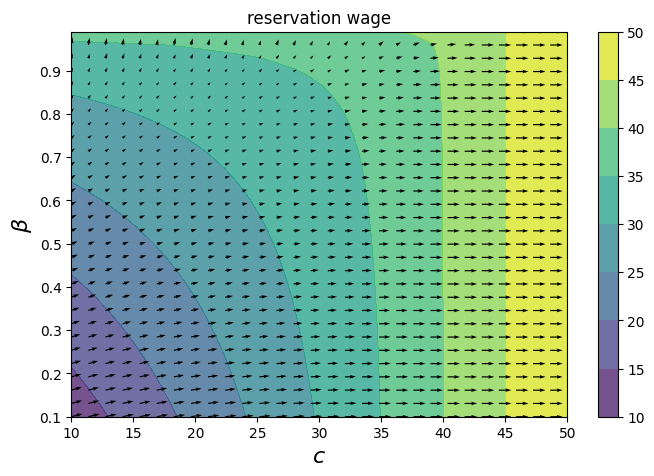

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
cc_grad, bb_grad = w_grad_grid_vals

cs1 = ax.contourf(cc, bb, w_bar_grid_vals, alpha=0.75)
ax.quiver(cc, bb, cc_grad, bb_grad / 100)

plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### Effect of the wage distribution

Since our entire problem is symbolic -- including the distribution over wage offers -- we can also study the effect of a shift in the wage distribution. To do this, we fix $\beta = 0.99$ and $c=25$, and instead vectorize $\alpha$, $\beta$, and $n$. 

We are interested in the effect of shifts in the moments of the distribution. For a Beta-Binominal, the first two raw moments are:

$$
\begin{align}
\mu &= np \\
\sigma^2 &= np(1 - p)[1 + (n-1)\rho ]
\end{align}
$$

Where $p = \frac{\alpha}{\alpha + \beta}$ and $\rho = \frac{1}{\alpha + \beta + 1}$

For this analysis, it's not helpful to have the problem written in terms of $\alpha$ and $\beta$ -- we'd like to ask questions like "what happens if the mean or variance of the wage distribution changes"? 

To do this, we can reparameterize the wage distribution in terms of $\mu$ and $\sigma$. Given a fixed $n$, we simply solve the two equations above for $\alpha$ and $\beta$:

$$
\begin{align}
\alpha &= \frac{\mu (\mu^2 - n \mu + \sigma ^2 )}{-\mu^2 + n \mu - n \sigma^2} \\
\beta &= \frac{(\mu - n) (\mu^2 - n \mu + \sigma^2 )}{\mu^2 - n \mu + n \sigma^2}
\end{align}
$$

We will re-use the graphs we've been using so far, merely replacing $\alpha$ and $\beta$ by these functions of $\mu$ and $\sigma$.

In [41]:
mu, sigma = pt.scalars('mu sigma'.split())
a_fn = mu * (mu ** 2 - mu * n + sigma ** 2) / (-mu ** 2 + mu * n - n * sigma ** 2)
b_fn = (mu - n) * (mu ** 2 - mu * n + sigma ** 2) / (mu ** 2 - mu * n + n * sigma ** 2)

w_bar_2 = pytensor.graph_replace(w_bar, {a: a_fn, b:b_fn})

To drive home what we've just done, we can look at what input values `w_bar_2` expects. Note that `a` and `b` no longer appear! Instead, it looks for `mu` and `sigma`.

In [42]:
from pytensor.graph.basic import explicit_graph_inputs
list(explicit_graph_inputs(w_bar_2))

[β, c, v0, n, w_min, w_max, mu, sigma]

We can check that our formulas are right by checking that we can make a "round trip" from the original parameterization of $a=200$, $b=100$

In [43]:
p = a / (a + b)
rho = 1 / (1 + a + b)

mu_val = (p * n).eval({a:200, b:100, n:50})
sigma_val = pt.sqrt(n * p * (1 - p) * (1 + (n - 1) * rho)).eval({a:200, b:100, n:50})

print(f'mu = {mu_val.item():0.3f}')
print(f'sigma = {sigma_val.item():0.3f}')

mu = 33.333
sigma = 3.594


In [44]:
print(f'a = {a_fn.eval({mu:mu_val, sigma:sigma_val, n:50}):0.2f}')
print(f'b = {b_fn.eval({mu:mu_val, sigma:sigma_val, n:50}):0.2f}')

a = 200.00
b = 100.00


We can also plot the distributions we get for different values of $\mu$ and $\sigma$

In [45]:
dist_args = [n, mu, sigma, w_min, w_max]
f = pytensor.function(dist_args, [w_support, 
                                  pytensor.graph_replace(q_probs, {a:a_fn, b:b_fn})])

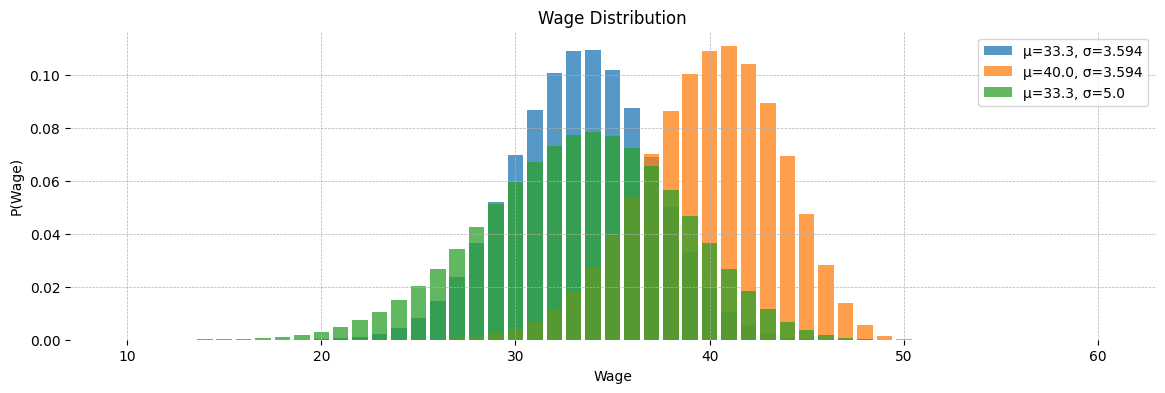

In [46]:
dist_params = {'n':50, 'mu':33.333, 'sigma':3.594, 'w_min':10, 'w_max':60}

fig, ax = plt.subplots(figsize=(14, 4))

ax.bar(*f(**dist_params), alpha=0.75, label='μ=33.3, σ=3.594')
ax.bar(*f(**dist_params | {'mu':40}), alpha=0.75, label='μ=40.0, σ=3.594')
ax.bar(*f(**dist_params | {'sigma': 5.0}), alpha=0.75, label='μ=33.3, σ=5.0')

ax.set(title='Wage Distribution', xlabel='Wage', ylabel='P(Wage)')
ax.legend()

ax.grid(ls='--', lw=0.5)
[spine.set_visible(False) for spine in ax.spines.values()]
plt.show()

Nice! Now let's vectorize w_bar over $\mu$ and $\sigma^2$, and make a contour plot with vector field

In [47]:
mu_grid, sigma_grid = pt.dmatrices('mu_grid', 'sigma_grid')
w_bar_dist_grads = pt.grad(w_bar_2, [mu, sigma])

w_bar_grid, *w_grad_grid = vectorize_graph([w_bar_2, *w_bar_dist_grads], {mu:mu_grid, sigma:sigma_grid})

TypeError: Only tensors with the same number of dimensions can be joined. Input ndims were: [3, 2, 2, 2]

In [48]:
fn_w_bar_dist = pytensor.function([v0, c, β, mu_grid, sigma_grid, n, w_min, w_max],
                                  [w_bar_grid, *w_grad_grid])

NameError: name 'w_bar_grid' is not defined

In [52]:
mu_values = np.linspace(15, 35, 30)
sigma_values = np.linspace(2.5, 10, 30)

mm, ss = np.meshgrid(mu_values, sigma_values)

w_bars, mu_grads, sigma_grads = fn_w_bar_dist(v0_value, c=25, β=0.99, mu_grid=mm, sigma_grid=ss,
                                              n=50, w_min=10, w_max=60)

From this last plot, we can see the effects of varying the mean (x-axis) and standard deviation (y-axis) of the wage distribution. Since we have access to the gradients, we can also see how the reservation wage changes at each grid point.

Perhaps unsurprisingly, as the mean wage increases, the reservation wage increases. The effect of variance, on the other hand, is revealed to be more complex. When the mean is low, the reservation wage is strictly decreasing in variance. But as the mean increases, there are "sweet spots" in variance, above and below which the reservation wage decreases.

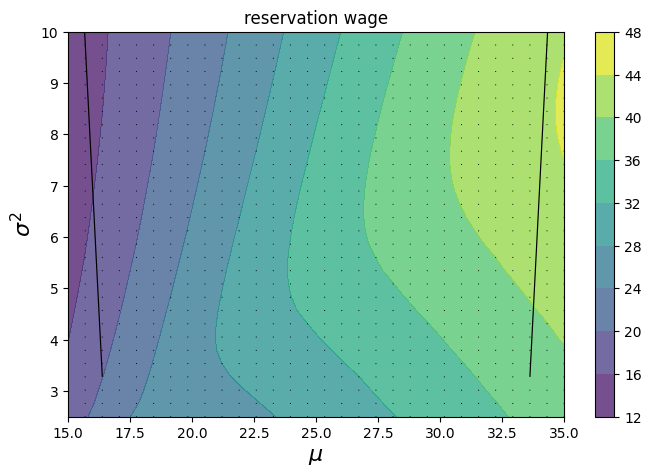

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))

cs1 = ax.contourf(mm, ss, w_bars, alpha=0.75)
ax.quiver(mm, ss, mu_grads, sigma_grads)

plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel(r"$\mu$", fontsize=16)
ax.set_ylabel(r"$\sigma^2$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

## Conclusion

Anyway, the key point is not the result of the analysis. Instead, we see how we can leverage the power of pytensor's symbolic graph manipulation to:

- Solve a root-finding problem
- Compute quantities of interest that depend on the solution
- Use graph transformations, including `graph_replace`, `vectorize_graph`, and `grad`, to push the analysis even further

## Authors

- Authored by Jesse Grabowski in June 2025

## References

:::{bibliography} :filter: docname in docnames

## Watermark 

In [54]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Jul 28 2025

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

pytensor: 2.31.3+5.gacd921952

sys       : 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
numpy     : 2.3.1
matplotlib: 3.10.3
pytensor  : 2.31.3+5.gacd921952

Watermark: 2.5.0

